In [1]:
import numpy as np
import pandas as pd
from mouselabdiscrete import NewMouselabEnv
from evaluation import *
from distributions import sample, expectation, Normal, Categorical, Mixture, PiecewiseUniform
import torch.nn as nn
import torch
from time import time

/is/sg2/amehta/virtualenvs/mouselab/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
num_datapoints = 10000
num_epochs = 5000
num_episodes = 500
num_test_episodes = 1000

In [3]:
gambles = 7
attributes = 4
high_stakes1 = Normal((9.99+0.01)/2, 0.3*(9.99-0.01))
high_stakes2 = Normal((9.99+0.01)/2, 0.9*(9.99-0.01))

#low_stakes = Normal((0.25+0.01)/2, 0.3*(0.25-0.01))
reward = high_stakes1
testreward = Mixture([high_stakes1, high_stakes2], [0.7, 0.3])
cost=0.05

alpha = 0.15
max_action = (gambles + 1)*attributes + 1

In [4]:
class BMPS_Approximator(nn.Module):
    def __init__(self, input_size, output_size):
        super(BMPS_Approximator, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.network = nn.Sequential(
                            nn.Linear(input_size, input_size//2),
                            nn.ReLU(),
                            nn.Linear(input_size // 2, input_size // 4),
                            nn.ReLU(),
                            nn.Linear(input_size // 4, input_size//8),
                            nn.ReLU(),
                            nn.Linear(input_size // 8, output_size)
                            )
    def forward(self, X):
        output = self.network(X)
        return output
    
    def train_epoch(self, train_X, train_Y, criterion, optimizer):
        output = self.forward(train_X)
        loss = criterion(output, train_Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss

def train_model(model, train_X, train_Y, criterion, optimizer, num_epochs=num_epochs):
    for epoch_num in range(1, num_epochs+1):
        if epoch_num % 1000 == 0:
            print(f"Epoch {epoch_num}")
        loss = model.train_epoch(train_X, train_Y, criterion, optimizer)
        if epoch_num % 1000 == 0:
            print(loss.item())


In [5]:
def create_tensors(feature_df, vpi=False):
    X = []
    Y = []
    for index, data in feature_df.iterrows():
        #x = []
        y = []
        x = data['beliefstate']
        if not vpi:
            x = np.concatenate((x, data['one_hot_action']))
        for f in ['expected_term_reward', 'cost']:
            x = np.append(x, data[f])
        #for f in features:
        #    x.append(data[f])
        for f in ['myopic_voc', 'vpi', 'vpi_action']:
            y.append(data[f])
        X.append(x)
        Y.append(y)
    return torch.tensor(X, requires_grad=True), torch.tensor(Y, requires_grad=True)

In [6]:
def gen_data(num_points, seed = None):
    if seed is not None:
        np.random.seed(seed)
    for i in range(num_points):
        env = NewMouselabEnv(gambles, attributes, reward, cost, alpha = alpha)
        
        #exclude terminal action while devising current state
        possible_actions = list(env.actions())[:-1]
        
        num_attributes = np.random.choice(attributes)
        num_actions = np.random.choice(attributes*gambles)
        
        attributes_taken = np.random.choice(possible_actions[:attributes], size = num_attributes, replace = False)
        actions_taken = np.random.choice(possible_actions[attributes:], size = num_actions, replace = False)

        actions_taken = np.concatenate((attributes_taken, actions_taken))
        
        for action in actions_taken:
            env._step(action)
        
        a = np.array(list(env.actions()))
        possible_actions = list(a[a < attributes])
        
        
        #possible_actions.append(env.term_action)
        
        action = np.random.choice(possible_actions)
        feats = env.action_features(action)
        
        state = np.vectorize(lambda g: expectation(g), otypes = [float])(env._state[1])
        
        #print(env.mus, env.vars)
        gamble_feats = env.mus
        
        yield (np.concatenate((env.dist, gamble_feats, state)), np.sort(actions_taken), action, *feats)


In [7]:
def get_one_hot_encoding(row):
    one_hot_action = np.zeros(max_action)
    one_hot_action[row.actions_taken] = 1
    one_hot_action[row.action] = 2
    return one_hot_action
    

In [8]:
t1 = time()

In [9]:
data = list(gen_data(num_datapoints))

In [10]:
df = pd.DataFrame(data, columns = ['beliefstate', 'actions_taken', 'action', 'cost','myopic_voc', 'vpi_action', 'vpi', 'expected_term_reward'])

In [11]:
df['one_hot_action'] = df.apply(get_one_hot_encoding, axis=1)

In [12]:
X, Y = create_tensors(df)

In [13]:
VPI_X, Y = create_tensors(df, vpi=True) # For VPI, we don't need the action vector

In [14]:
myopic_voc_approx = BMPS_Approximator(X.shape[-1], 1)
vpi_approx = BMPS_Approximator(VPI_X.shape[-1], 1)
vpi_action_approx = BMPS_Approximator(X.shape[-1], 1)

In [15]:
# Hyperparam
learning_rate = 1e-4

criterion = nn.MSELoss()
# Optimizers
mvoc_optimizer = torch.optim.Adam(myopic_voc_approx.parameters(), lr=learning_rate)
vpi_action_optimizer = torch.optim.Adam(vpi_action_approx.parameters(), lr=learning_rate)
vpi_optimizer = torch.optim.Adam(vpi_approx.parameters(), lr=learning_rate*10)

# Train the networks
train_model(vpi_approx, VPI_X.float(), Y[:, 1].unsqueeze_(1), criterion, vpi_optimizer)
train_model(vpi_action_approx, X.float(), Y[:, 2].unsqueeze_(1), criterion, vpi_action_optimizer)
train_model(myopic_voc_approx, X.float(), Y[:, 0].unsqueeze_(1), criterion, mvoc_optimizer)

#create_dir("voc_models")
torch.save(vpi_approx.state_dict(), "voc_models/vpinorm.pth")
torch.save(vpi_action_approx.state_dict(), "voc_models/vpi_action_attributesnorm.pth")
torch.save(myopic_voc_approx.state_dict(), "voc_models/myopic_voc_attributesnorm.pth")


Epoch 1000
0.2581784725189209
Epoch 2000
0.2513713240623474
Epoch 3000
0.24681079387664795
Epoch 4000
0.24477209150791168
Epoch 5000
0.24359558522701263
Epoch 1000
0.42170628905296326
Epoch 2000
0.3554093539714813
Epoch 3000
0.33118969202041626
Epoch 4000
0.310453861951828
Epoch 5000
0.2943932116031647
Epoch 1000
0.355408638715744
Epoch 2000
0.27994853258132935
Epoch 3000
0.2110375016927719
Epoch 4000
0.1630232185125351
Epoch 5000
0.13193942606449127


In [16]:
t2 = time()

In [17]:
t2 - t1

637.0419762134552

---

## Bayesian Optimization

In [18]:
import GPyOpt
import GPy

In [19]:
env_array = []

def make_train_envs(num_episodes = num_episodes):
    np.random.seed(1000)
    for i in range(num_episodes):
        env = NewMouselabEnv(gambles, attributes, reward, cost, alpha=alpha)
        env_array.append(env)

make_train_envs()        


def blackboxfunc(W):
    
    #num_episodes = 5
    
    w1 = W[:,0]
    w2 = W[:,1]
    w3 = 1 - w1 - w2
    w4 = W[:,2]
    
    def voc_estimate(action):
        if action < attributes:
            state = np.vectorize(lambda g: expectation(g), otypes = [float])(env._state[1])
            gamble_feats = env.mus
            vpi_x = np.concatenate((env.dist, gamble_feats, state))
        
            one_hot_action = np.zeros(max_action)
            one_hot_action[actions_taken] = 1
            one_hot_action[action] = 2
        
            term_reward = env.expected_term_reward()
            x = np.concatenate((vpi_x, one_hot_action))
            vpi_x = np.append(vpi_x, [term_reward, env.cost])
            x = np.append(x, [term_reward, env.cost])
        
            X = torch.Tensor([x])
            VPI_X = torch.Tensor([vpi_x])
        
            myopic_voc = myopic_voc_approx(X)[0].item()
            vpi_action = vpi_action_approx(X)[0].item()
            vpi = vpi_approx(VPI_X)[0].item()
        
            return w1*myopic_voc + w2*vpi + w3*vpi_action + w4*env.cost
        
        elif action < env.term_action:
            #features = env.action_features(action)
            #features[0] is cost(action)
            #features[1] is myopicVOC(action) [aka VOI]
            #features[2] is vpi_action [aka VPIsub; the value of perfect info of branch]
            #features[3] is vpi(beliefstate)
            #features[4] is expected term reward of current state
            state = np.vectorize(lambda g: expectation(g), otypes = [float])(env._state[1])
            gamble_feats = env.mus
            vpi_x = np.concatenate((env.dist, gamble_feats, state))
        
            term_reward = env.expected_term_reward()
            vpi_x = np.append(vpi_x, [term_reward, env.cost])
            VPI_X = torch.Tensor([vpi_x])
            vpi = vpi_approx(VPI_X)[0].item()
            
            myopic_voc = env.myopic_voi(action)
            vpi_action = env.vpi_action(action//env.outcomes)
            
            return w1*myopic_voc + w2*vpi + w3*vpi_action + w4*env.cost
            
            #return w1*features[1] + w2*features[3] + w3*features[2] + w4*features[0]
        else:
            return 0
        
    cumreturn = 0
    
#    for i in range(num_episodes):
#        env = NewMouselabEnv(gambles, attributes, reward, cost, alpha=0.15)
    for env in env_array:

        exp_return = 0
        actions_taken = []
        
        while True:
            possible_actions = list(env.actions())

            #take action that maximises estimated VOC
            action_taken = max(possible_actions, key = voc_estimate)

            _, rew, done, _=env._step(action_taken)
            
            exp_return+=rew
            actions_taken.append(action_taken)
            
            if done:
                env._reset()
                break
        
        cumreturn += exp_return
        #print(exp_return)
    
    print(cumreturn/num_episodes)
    return -cumreturn/num_episodes

In [20]:
#pbounds = {'w1': (0,1), 'w2': (0,1), 'w3': (0,1), 'w4':(1,12)}
space = [{'name': 'w1', 'type': 'continuous', 'domain': (0,1)},
         {'name': 'w2', 'type': 'continuous', 'domain': (0,1)},
         {'name': 'w4', 'type': 'continuous', 'domain': (1,32)}]

constraints = [{'name': 'part_1', 'constraint': 'x[:,0] + x[:,1] - 1'}]

feasible_region = GPyOpt.Design_space(space = space, constraints = constraints)

In [21]:
# --- CHOOSE the intial design
from numpy.random import seed # fixed seed
seed(123456)

initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 10)

In [22]:
# --- CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(blackboxfunc)

# --- CHOOSE the model type
#This model does Maximum likelihood estimation of the hyper-parameters.
model = GPyOpt.models.GPModel(exact_feval=True,optimize_restarts=10,verbose=False)

# --- CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

# --- CHOOSE the type of acquisition
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, feasible_region, optimizer=aquisition_optimizer)

# --- CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

In [23]:
bo = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)

In [24]:
# --- Stop conditions
max_time  = 60000 
tolerance = 1e-4    # distance between two consecutive observations  

In [25]:
# Run the optimization  
bt1 = time()
max_iter  = 20
bo.run_optimization(max_iter = max_iter, max_time = max_time, eps = tolerance, verbosity=True) 
bt2 = time()

6.952430019100241
7.767319052948283
7.420991319840058
6.431366342354297
7.590368611844233
5.0
7.494054293974637
7.804603299019668
6.996246314639629
5.0
7.1783800006399465
num acquisition: 1, time elapsed: 345.79s
5.7426212514703545
num acquisition: 2, time elapsed: 427.50s
7.614135472365509
num acquisition: 3, time elapsed: 670.12s
7.4230007280704795
num acquisition: 4, time elapsed: 953.70s
7.347620026199932
num acquisition: 5, time elapsed: 1258.82s
7.433738445782004
num acquisition: 6, time elapsed: 1470.77s
7.315708007698991
num acquisition: 7, time elapsed: 1738.97s
7.3757517040510985
num acquisition: 8, time elapsed: 1897.80s
5.0
num acquisition: 9, time elapsed: 1920.11s
7.489062195874679
num acquisition: 10, time elapsed: 2158.97s
7.352533606630092
num acquisition: 11, time elapsed: 2453.99s
7.369767995205328
num acquisition: 12, time elapsed: 2741.69s
7.498004530247926
num acquisition: 13, time elapsed: 2928.14s
7.4354817374769135
num acquisition: 14, time elapsed: 3181.48s
7.

In [26]:
bo.x_opt

array([0.405, 0.118, 3.974])

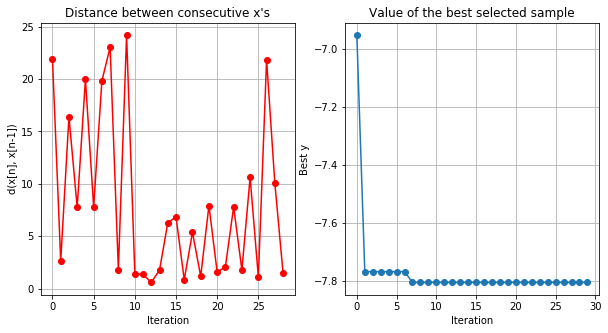

In [27]:
bo.plot_acquisition()
bo.plot_convergence()

In [28]:
bt2 - bt1

5528.9866852760315

---

## Testing

In [29]:
optimal_weights = bo.x_opt
#optimal_weights = np.array([0.019, 0.91 , 3.511])

In [30]:
sample_term_reward = True

In [31]:
def testfunc(W):
    
    #num_episodes = 5
    
    w1 = W[:,0]
    w2 = W[:,1]
    w3 = 1 - w1 - w2
    w4 = W[:,2]
    
    def voc_estimate(action):
        if action < attributes:
            state = np.vectorize(lambda g: expectation(g), otypes = [float])(env._state[1])
            gamble_feats = env.mus
            vpi_x = np.concatenate((env.dist, gamble_feats, state))
        
            one_hot_action = np.zeros(max_action)
            one_hot_action[actions_taken] = 1
            one_hot_action[action] = 2
        
            term_reward = env.expected_term_reward()
            x = np.concatenate((vpi_x, one_hot_action))
            vpi_x = np.append(vpi_x, [term_reward, env.cost])
            x = np.append(x, [term_reward, env.cost])
        
            X = torch.Tensor([x])
            VPI_X = torch.Tensor([vpi_x])
        
            myopic_voc = myopic_voc_approx(X)[0].item()
            vpi_action = vpi_action_approx(X)[0].item()
            vpi = vpi_approx(VPI_X)[0].item()
        
            return w1*myopic_voc + w2*vpi + w3*vpi_action + w4*env.cost
        
        elif action < env.term_action:
            #features = env.action_features(action)
            #features[0] is cost(action)
            #features[1] is myopicVOC(action) [aka VOI]
            #features[2] is vpi_action [aka VPIsub; the value of perfect info of branch]
            #features[3] is vpi(beliefstate)
            #features[4] is expected term reward of current state
            state = np.vectorize(lambda g: expectation(g), otypes = [float])(env._state[1])
            gamble_feats = env.mus
            vpi_x = np.concatenate((env.dist, gamble_feats, state))
        
            term_reward = env.expected_term_reward()
            vpi_x = np.append(vpi_x, [term_reward, env.cost])
            VPI_X = torch.Tensor([vpi_x])
            vpi = vpi_approx(VPI_X)[0].item()
            
            myopic_voc = env.myopic_voi(action)
            vpi_action = env.vpi_action(action//env.outcomes)
            
            return w1*myopic_voc + w2*vpi + w3*vpi_action + w4*env.cost
            
            #return w1*features[1] + w2*features[3] + w3*features[2] + w4*features[0]
        else:
            return 0
    
    cumreturn = 0
    
    np.random.seed(100)
    
    for i in range(num_test_episodes):
        env = NewMouselabEnv(gambles, attributes, reward, cost, ground_truth_dist = testreward, alpha=alpha, sample_term_reward = sample_term_reward)
    #for env in env_array:

        exp_return = 0
        actions_taken = []
        
        while True:
            possible_actions = list(env.actions())

            #take action that maximises estimated VOC
            action_taken = max(possible_actions, key = voc_estimate)

            _, rew, done, _=env._step(action_taken)
            
            exp_return+=rew
            actions_taken.append(action_taken)
            
            if done:
                #env._reset()
                break
        
        cumreturn += exp_return
        #print(exp_return)
    
    print(cumreturn/num_test_episodes)
    return -cumreturn/num_test_episodes

In [32]:
testfunc(np.array([optimal_weights]))